In [1]:
import numpy as np
import pandas as pd
import time
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
#from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка основного датафрейма с результатами голосований
df_full = pd.read_csv('./data/df_full_cr_0.csv', index_col=0)

In [3]:
df_full.head()

,law_name,vote_result,Авдеев Александр Александрович,Адучиев Батор Канурович,Азимов Рахим Азизбоевич,Аксаков Анатолий Геннадьевич,Алексеева Татьяна Олеговна,Альшевских Андрей Геннадьевич,Ананских Игорь Александрович,Аникеев Григорий Викторович,...,Эмиргамзаев Абдулгамид Гасанович,Юмашева Инга Альбертовна,Юрков Дмитрий Васильевич,Ющенко Александр Андреевич,Ямпольская Елена Александровна,Яровая Ирина Анатольевна,Антошкин Николай Тимофеевич,Зиннуров Ирек Хайдарович,Кобзев Юрий Викторович,Шурчанов Валентин Сергеевич
113991,(за основу) О проекте порядка работы Государст...,принят,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0
113990,Регистрация 12:01.02,принят,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
113989,(первое чтение) О проекте федерального закона ...,отклонен,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
113988,(первое чтение) О проекте федерального закона ...,отклонен,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,-1.0
113987,(первое чтение) О проекте федерального закона ...,принят,-1,0,-1,-1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0


2 - не голосовал, 1 - "против", 0 - воздержался, -1 - "за"

# Анализ текстов

In [4]:
df_full.vote_result.value_counts()

принят         12142
отклонен        3251
Рейтинговое      151
Name: vote_result, dtype: int64

In [5]:
# Удаление "рейтинговых" голосований
df_lem = df_full.drop(index=df_full[df_full['vote_result'] == 'Рейтинговое'].index)
df_lem.vote_result.value_counts()

принят      12142
отклонен     3251
Name: vote_result, dtype: int64

In [6]:
# Перекодирование таргета в числовую форму
df_lem.vote_result = df_lem.vote_result.map(lambda s: 1 if s=='принят' else 0)
df_lem.vote_result.value_counts()

1    12142
0     3251
Name: vote_result, dtype: int64

In [7]:
# Список с текстами вопросов голосования
law_list_p = df_lem.law_name.astype('str').tolist()

In [8]:
# Функция лемматизации с объединением текстов в один большой (для увеличения скорости работы pymystem3)
def lemma3(text):
    m = Mystem()
    merged_text = "".join(txt + ' br ' for txt in text)

    doc = ''
    res = []

    for t in m.lemmatize(merged_text):
        if t != '\n':
            if t != 'br':
                doc += t
            else:
                res.append(doc)
                doc = ''

    return res

In [9]:
text_batch = [law_list_p[i: i + 1000] for i in range(0, len(law_list_p), 1000)]

In [10]:
# Лемматизация с использованием всех ядер процессора
law_list_p_clean = Parallel(n_jobs=-1)(delayed(lemma3)(t) for t in tqdm(text_batch))

In [11]:
# Пересобрание списка с текстами вопросов голосований
law_list_p_clean_list = []
for l in law_list_p_clean:
    for b in l:
        law_list_p_clean_list.append(b)

In [12]:
len(law_list_p_clean_list)

15393

In [13]:
df_law_clean = pd.DataFrame(law_list_p_clean_list)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df_law_clean[0], 
    df_lem.vote_result, 
    test_size=0.3,
    stratify = df_lem.vote_result,
    random_state = 7
)

In [15]:
len(stopwords.words('russian'))

151

### Векторизация

In [16]:
v = TfidfVectorizer(stop_words=stopwords.words('russian'), ngram_range=(1, 2), max_df=0.95, min_df=0.002, norm=None)

In [17]:
X_train_tfid = v.fit_transform(X_train).todense()
X_test_tfid = v.transform(X_test).todense()

In [18]:
X_train_tfid.shape

(10775, 2107)

In [19]:
X_test_tfid.shape

(4618, 2107)

In [38]:
# Функции вывода метрик классификации

def dataframe_quality_metrics(prediction, actual):
    stats = [
#        accuracy_score(prediction, actual),
#        precision_score(prediction, actual),
#        recall_score(prediction, actual),
#        f1_score(prediction, actual)
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction)
    ]
    return stats

measured_quality_metrics = pd.DataFrame({"Test_quality":["Accuracy", "Precision", "Recall", "f1_score"]})
measured_quality_metrics.set_index("Test_quality")

def metrics_all(models_dict):
    measured_quality_metrics = pd.DataFrame({"Test_quality":["Accuracy", "Precision", "Recall", "f1_score"]})
    measured_quality_metrics.set_index("Test_quality")
    
    y_test_baseline = np.array([1]*len(y_test))
    measured_quality_metrics["baseline"] = dataframe_quality_metrics(y_test_baseline, y_test)

    for model_name in models_dict:
        measured_quality_metrics[model_name] = dataframe_quality_metrics(models_dict[model_name].predict(X_test_tfid), y_test)

    return measured_quality_metrics

In [21]:
# Логистическая регрессия

log_reg = LogisticRegressionCV()
log_reg.fit(X_train_tfid, y_train)

log_reg_pred = log_reg.predict(X_test_tfid)

In [22]:
# Random Forest

RF_clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, random_state=7)
RF_clf.fit(X_train_tfid, y_train)

RandomForestClassifier(min_samples_split=3, n_estimators=400, random_state=7)

In [23]:
# Градиентный бустинг (sklearn)

GB_clf = GradientBoostingClassifier(random_state=7)
GB_clf.fit(X_train_tfid, y_train)

GradientBoostingClassifier(random_state=7)

In [24]:
# XGB

XGB_clf = XGBClassifier(n_jobs=-1, random_state=7)
XGB_clf.fit(X_train_tfid, y_train)

[18:47:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# LightGBM

LGBM_clf = LGBMClassifier(n_jobs=-1, random_state=7)
LGBM_clf.fit(X_train_tfid, y_train)

LGBMClassifier(random_state=7)

In [26]:
# kNN

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_tfid, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
# Расчёт всех метрик и вывод таблицы

models_list = [log_reg, RF_clf, GB_clf, XGB_clf, knn_clf]
models_dict = {'log_reg': log_reg, 'RF_clf': RF_clf, 'GB_clf': GB_clf, 'XGB_clf': XGB_clf, 'LGBM_clf': LGBM_clf, 'knn_clf': knn_clf}

metrics_all(models_dict)

,Test_quality,baseline,log_reg,RF_clf,GB_clf,XGB_clf,LGBM_clf,knn_clf
0,Accuracy,0.788870,0.890645,0.902772,0.881767,0.898874,0.896925,0.873105
1,Precision,0.788870,0.916180,0.924057,0.883577,0.929421,0.928089,0.885693
2,Recall,1.000000,0.948120,0.955257,0.979138,0.943453,0.942355,0.963492
3,f1_score,0.881976,0.931876,0.939398,0.928906,0.936385,0.935168,0.922956


In [28]:
# Функции построение кривых ROC AUC

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()
    
def plot_roc_curve_all(models_dict):
    i = 1
    ax = {}
    row_len = 3
    nrows = len(models_dict) // row_len + 1

    plt.figure(figsize=(20,18))    
    
    for model_name in models_dict:
        #plot_roc_curve(model.predict_proba(X_test_tfid)[:,1], y_test)

        prob_prediction = models_dict[model_name].predict_proba(X_test_tfid)[:,1]
        
        fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
        auc_score = roc_auc_score(y_test, prob_prediction)
        
        ax[i] = plt.subplot(nrows, row_len, i)
        ax[i].plot(fpr, tpr, label='ROC curve ')
        ax[i].plot([0, 1], [0, 1])
        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.05])
        ax[i].set_xlabel('False Positive Rate')
        ax[i].set_ylabel('True Positive Rate')
        ax[i].set_title('{} ROC AUC: {:.3f}'.format(model_name, auc_score))
        i += 1
    
    plt.show()

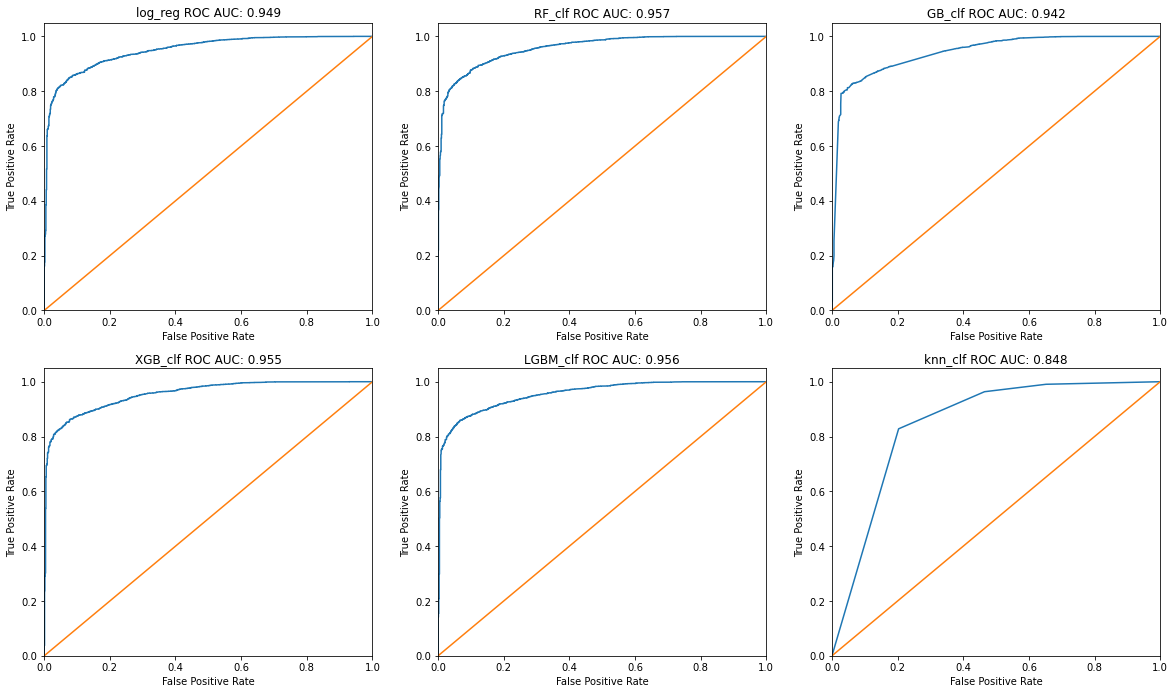

In [29]:
plot_roc_curve_all(models_dict)

Все модели справились неплохо, кроме kNN, у которого получились низкие Accuracy и Recall

### Оценка важных слов и словосочетаний для предсказания результата

In [30]:
df = pd.DataFrame(
    X_train_tfid, 
    columns=v.get_feature_names()
)

<AxesSubplot:xlabel='feature'>

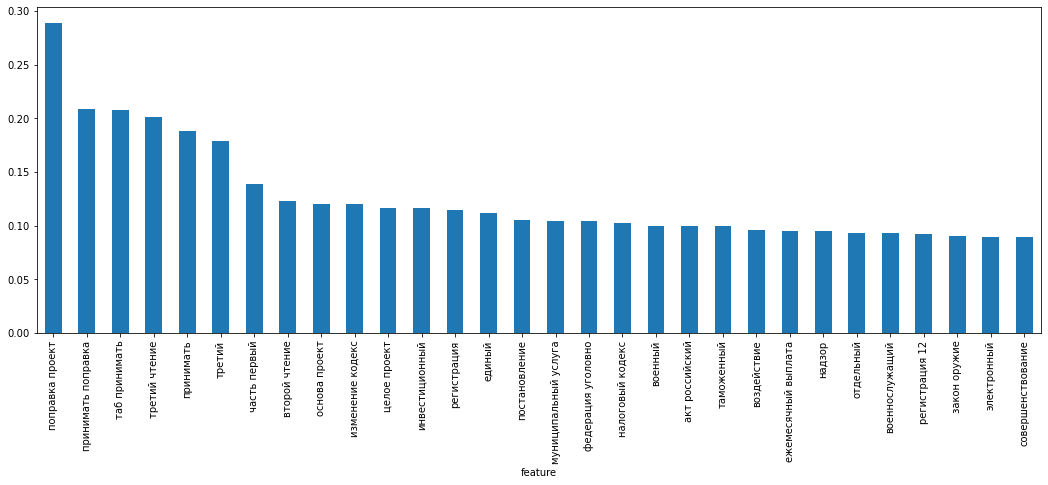

In [31]:
featureImportance = pd.DataFrame({"feature": df.columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"][:30].plot(kind='bar', figsize=(18, 6))

<AxesSubplot:xlabel='feature'>

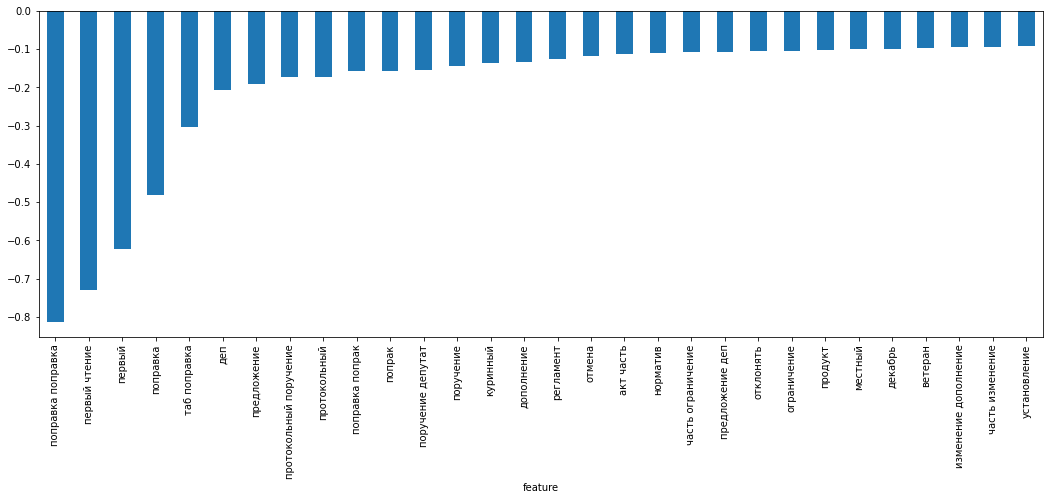

In [32]:
featureImportance = pd.DataFrame({"feature": df.columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=True, inplace=True)
featureImportance["importance"][:30].plot(kind='bar', figsize=(18, 6))

Вывод полного текста вопросов голосования, в которых встречались странные словосочетания из графиков выше.

In [33]:
for e, l in enumerate(law_list_p_clean_list):
    if 'принимать поправка' in l:
        print(law_list_p[e])

* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 279800-7 "О внесении изменений в Федеральный закон "Об электроэнергетике" в части регулирования отношений при присоединении электроэнергетической системы к другой электроэнергетической системе"
* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 322981-7 "О внесении изменений в Федеральный закон "Об участии в долевом строительстве многоквартирных домов и иных объектов недвижимости и о внесении изменений в некоторые законодательные акты Российской Федерации" и отдельные законодательные акты Российской Федерации"
(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 73983-5 "О внесении изменений в статью 72 Уголовного кодекса Российской Федерации" (по вопросу зачета времени содержания лица под стражей до вступления приговора суда в законную силу в срок отбывания наказания в виде лишения свободы)
(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 706820-7 "О внесении изме

(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 80283-7 "О внесении изменений в статью 350 Трудового кодекса Российской Федерации" (об установлении предельного возраста для замещения должностей руководителей и заместителей руководителей государственных и муниципальных медицинских организаций)
* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 185907-7 "Об инновационных научно-технологических центрах и о внесении изменений в отдельные законодательные акты Российской Федерации"
* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 161450-7 "О внесении изменений в Федеральный закон "О связи" (в части уточнения процедуры заключения договоров об оказании услуг связи)
(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 195446-7 "О внесении изменений в Федеральный закон "Об информации, информационных технологиях и о защите информации" (в части уточнения порядка ограничения доступа к информационным ресурсам)
*(2 чтение таб.

In [34]:
for e, l in enumerate(law_list_p_clean_list):
    if 'поправка поправка' in l:
        print(law_list_p[e])

(2 чтение таб. 2 отклонённые поправки поправка № 2) О проекте федерального закона № 1060689-7 "О внесении изменений в Кодекс Российской Федерации об административных правонарушениях" (об усилении ответственности за нарушения при подготовке и проведении публичных мероприятий)
(2 чтение таб. 2 отклонённые поправки поправка № 1) О проекте федерального закона № 1060689-7 "О внесении изменений в Кодекс Российской Федерации об административных правонарушениях" (об усилении ответственности за нарушения при подготовке и проведении публичных мероприятий)
* (2 чтение таб. 1 принятые поправки поправка № 12) О проекте федерального закона № 984546-7 "О внесении изменений в часть вторую Налогового кодекса Российской Федерации в части введения обратного акциза на этан, сжиженные углеводородные газы и инвестиционного коэффициента, применяемого при определении размера обратного акциза на нефтяное сырье"
* (2 чтение таб. 1 принятые поправки поправка №4) О проекте закона Российской Федерации о поправке к

Text(0.5, 0, 'Xgboost Feature Importance')

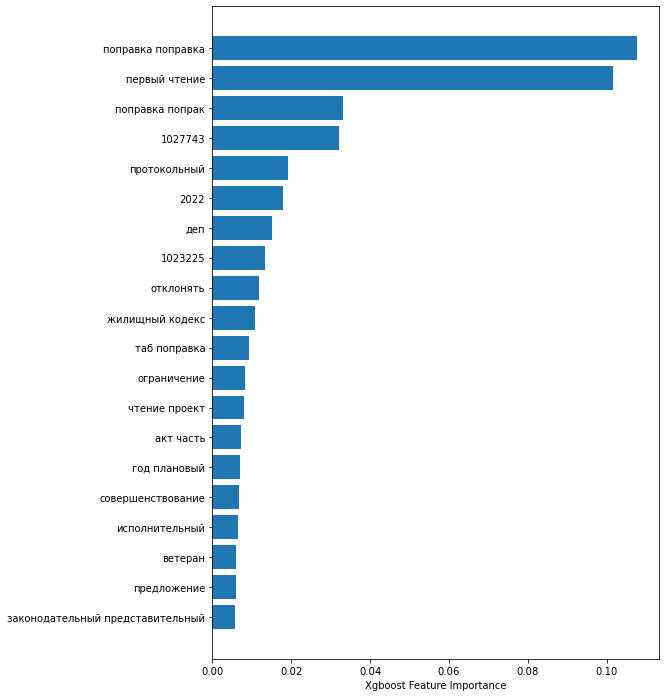

In [35]:
# Важность признаков для модели XGB
sorted_idx = XGB_clf.feature_importances_.argsort()[::-1][:20]
feature_names = np.array(v.get_feature_names())

plt.figure(figsize=(8,12))
plt.barh(feature_names[sorted_idx][::-1], XGB_clf.feature_importances_[sorted_idx][::-1])
plt.xlabel("Xgboost Feature Importance")